## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Camera Calibration

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


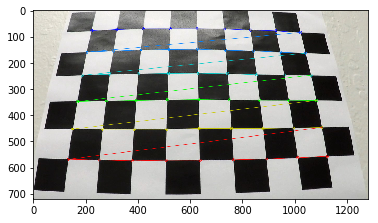

In [2]:
#reading in an image
calibration_example = mpimg.imread('camera_cal/calibration3.jpg')
chess_shape = (9,6)
#printing out some stats and plotting
calibration_gray = cv2.cvtColor(calibration_example, cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(calibration_gray,(9,6))
cv2.drawChessboardCorners(calibration_example, (9,6), corners, ret)
print('This image is:', type(calibration_example), 'with dimensions:', calibration_example.shape)
plt.imshow(calibration_example)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [3]:
%pdb
import glob

def calibrate_camera(file_pattern, chess_shape):
    images = glob.glob(file_pattern)

    objpoints = []
    imgpoints = []

    objp = np.float32([(x,y,0) for x in range(chess_shape[1]) for y in range(chess_shape[0])])
    gray = None
    for image_file in images:
        image = mpimg.imread(image_file)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,chess_shape)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)

    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

ret, mtx, dist, rvecs, tvecs = calibrate_camera('camera_cal/calibration*.jpg', (9,6))

Automatic pdb calling has been turned ON


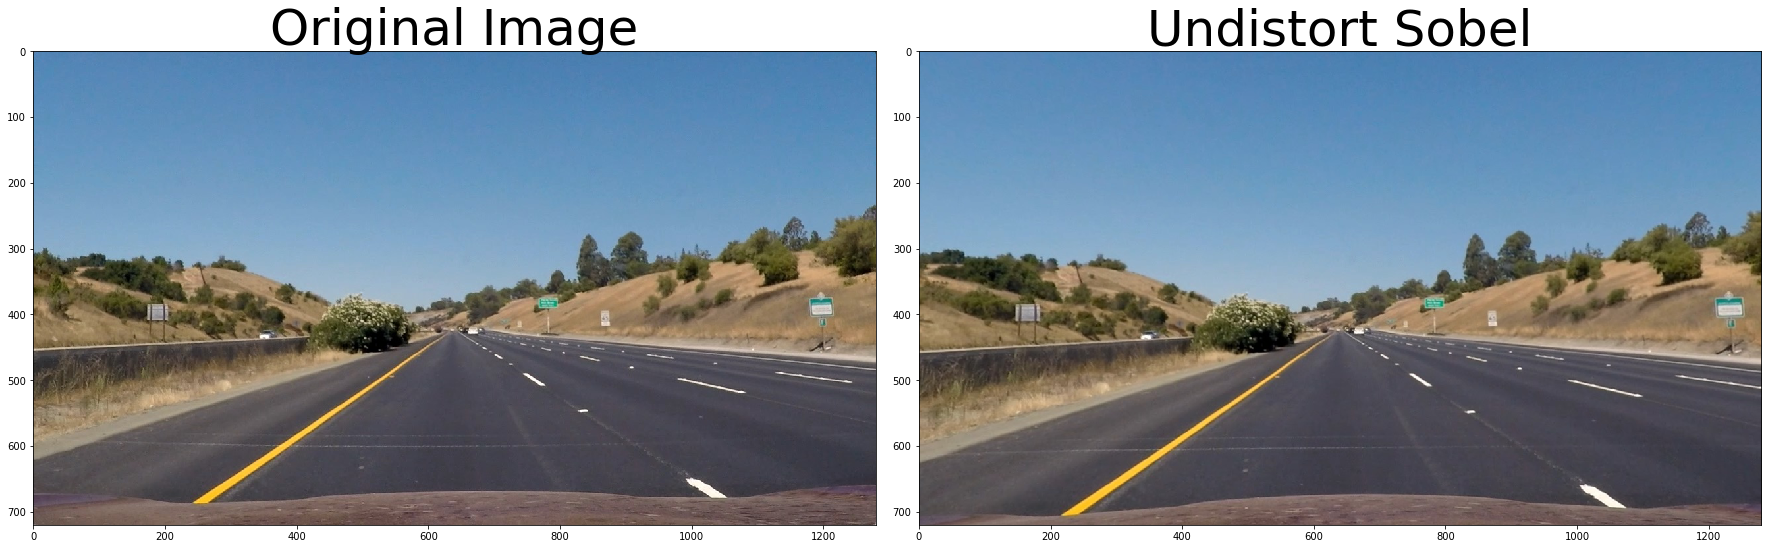

In [4]:
calibration_example = mpimg.imread('test_images/straight_lines1.jpg')

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))

f.tight_layout()

ax1.imshow(calibration_example)
ax1.set_title('Original Image', fontsize=50)

mpimg.imsave('test_images/straight_lines1_undist.png', cv2.undistort(calibration_example, mtx, dist, None, mtx))

ax2.imshow(mpimg.imread('test_images/straight_lines1_undist.png'))
ax2.set_title('Undistort Sobel', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Threshold Pixels

#### Sobel/Gradient filtering

In [5]:
"""Sobel Thresholding"""
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

def abs_sobel_thresh(single_channel, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Calculate the x and y gradients
    if orient == 'x':
        sobel = cv2.Sobel(single_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(single_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary =  np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Apply threshold
    return grad_binary

def mag_thresh(single_channel, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Calculate directional gradient
    # Calculate the x and y gradients
    sobel = [cv2.Sobel(single_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel),
             cv2.Sobel(single_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)]
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    mag_sobel = np.linalg.norm(sobel, axis=0)
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    mag_binary =  np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # Apply threshold
    return mag_binary

def dir_threshold(single_channel, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(single_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(single_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    scaled_sobel = np.uint8(255*absgraddir/np.max(absgraddir))
    dir_binary =  np.zeros_like(scaled_sobel)
    dir_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Apply threshold
    return dir_binary


# Apply each of the thresholding functions
def sobel_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,2]
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(40, 200))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(10, 150))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(80, 250))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(10*np.pi/180, 70*np.pi/180))
    # Run the function
    sobel_combined = np.zeros_like(dir_binary)
    sobel_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 255
    return sobel_combined

#### Color filtering

In [6]:
yellow_range= (np.array([19,100,100], dtype=np.uint8),
               np.array([25,255,255], dtype=np.uint8))
white_range = (np.array([0,             0,70 *255//100], dtype=np.uint8),
               np.array([179, 5 *255//100,         255], dtype=np.uint8))
white_range2= (np.array([  0,           0,90 *255//100], dtype=np.uint8),
               np.array([179,12 *255//100,         255], dtype=np.uint8))

def color_threshold(image):
    # Change to a better suited color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # Threshold the HSV image, white is broken into to ranges, because of its behavior on HSV
    white_mask = cv2.bitwise_or(cv2.inRange(hsv, *white_range), cv2.inRange(hsv, *white_range2))
    yellow_mask = cv2.inRange(hsv, *yellow_range)
    # Add masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
#     # Dilate masks to include borders
#     mask = cv2.dilate(mask, None, iterations=5)  
#     mask = cv2.erode(mask, None, iterations=3)
    return mask


#### Combined filtering

In [7]:
def pixels_threshold(image):
    combined_threshold =  cv2.bitwise_or(color_threshold(image), sobel_threshold(image))
    return cv2.morphologyEx(combined_threshold, cv2.MORPH_OPEN, (ksize,ksize))

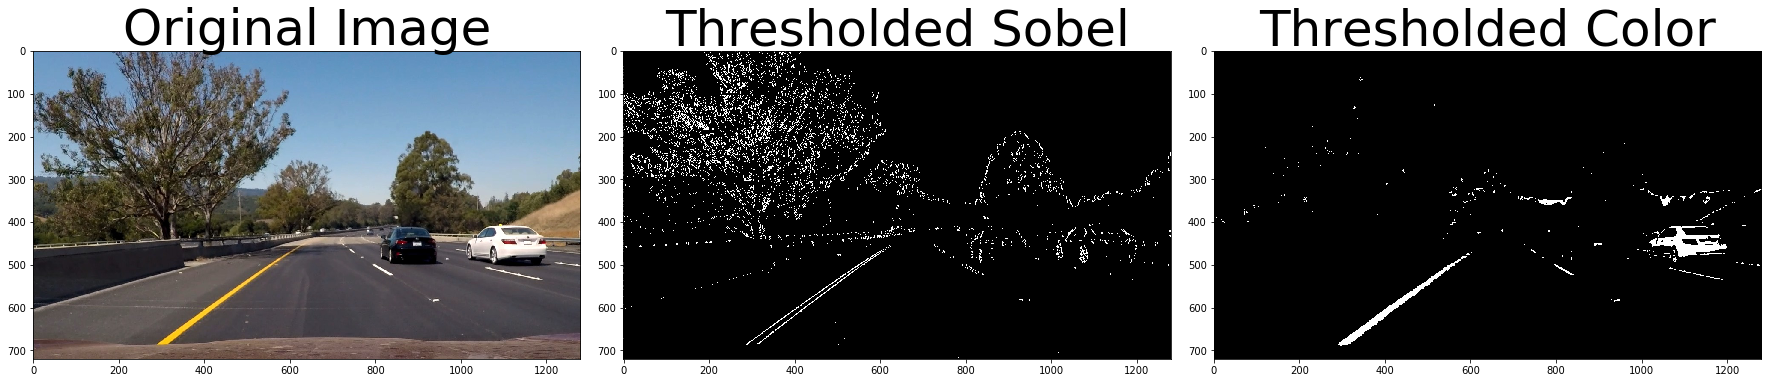

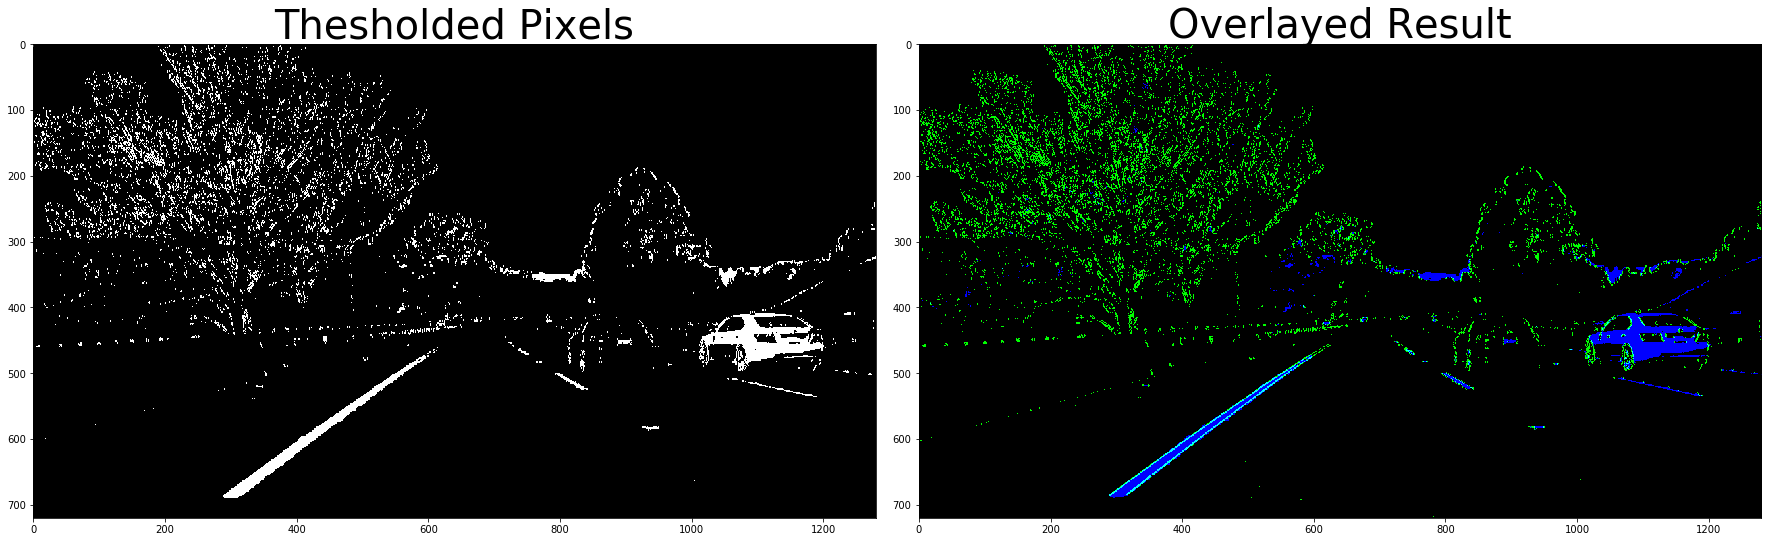

In [8]:
image = mpimg.imread('test_images/test6.jpg')
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))

f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
sobel_image = sobel_threshold(image)
ax2.imshow(sobel_image, cmap='gray')
ax2.set_title('Thresholded Sobel', fontsize=50)
color_image = color_threshold(image)
ax3.imshow(color_image, cmap='gray')
ax3.set_title('Thresholded Color', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Stack each channel
combined_binary = np.dstack(( np.zeros_like(sobel_image), sobel_image , color_image))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(pixels_threshold(image), cmap='gray')
ax1.set_title('Thesholded Pixels', fontsize=40)

ax2.imshow(combined_binary)
ax2.set_title('Overlayed Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transformation ("birds-eye view")

In [9]:
# src = np.float32((
#     (207, 720),
#     (624, 432),
#     (655, 432),
#     (1104, 720)
# ))
# dst = np.float32((
#     (207, 720),
#     (207, 0),
#     (1104, 0),
#     (1104, 720)
# ))
src = np.float32((
    (207, 720),
    (591, 453),
    (692, 453),
    (1104, 720)
))
dst = np.float32((
    (320, 720),
    (320, 0),
    (960, 0),
    (960, 720)
))
# dst = np.float32((
#     (207, 720),
#     (207, 0),
#     (1104, 0),
#     (1104, 720)
# ))
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
def bird_eye(image):
    return cv2.warpPerspective(image, M, image.shape[1::-1])

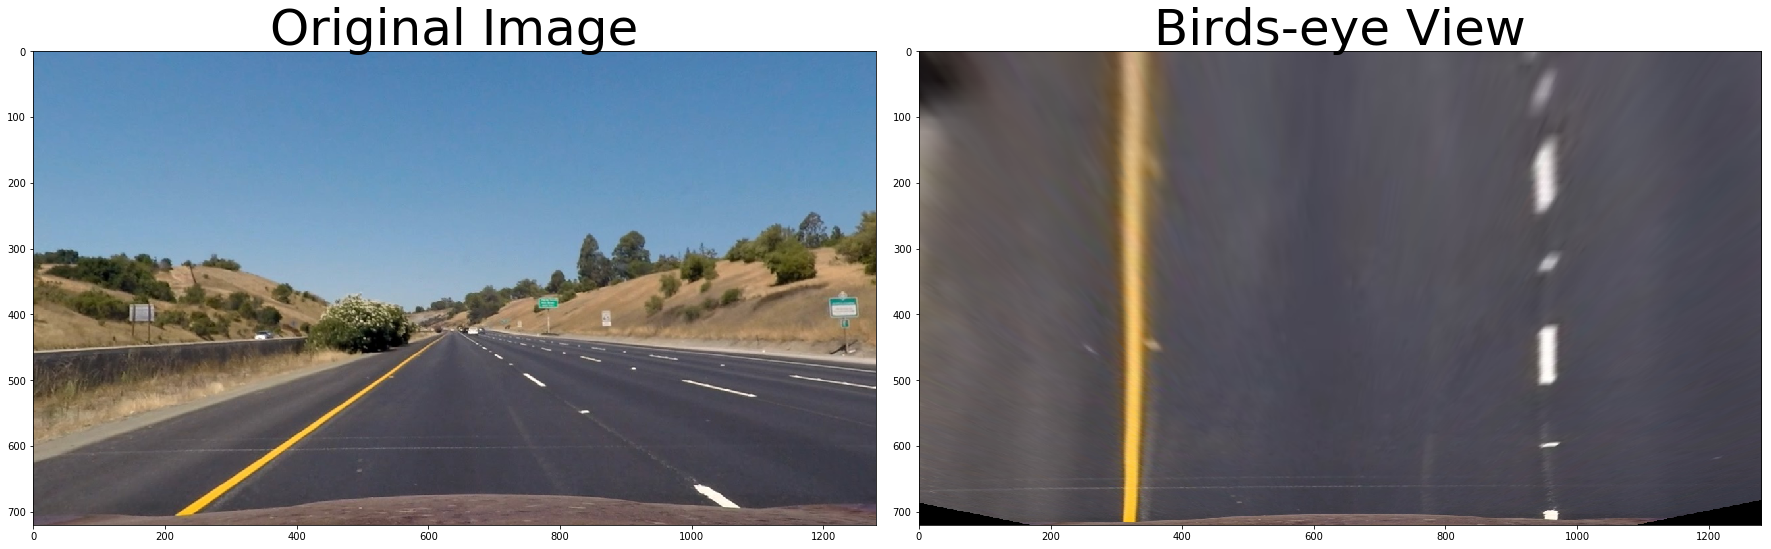

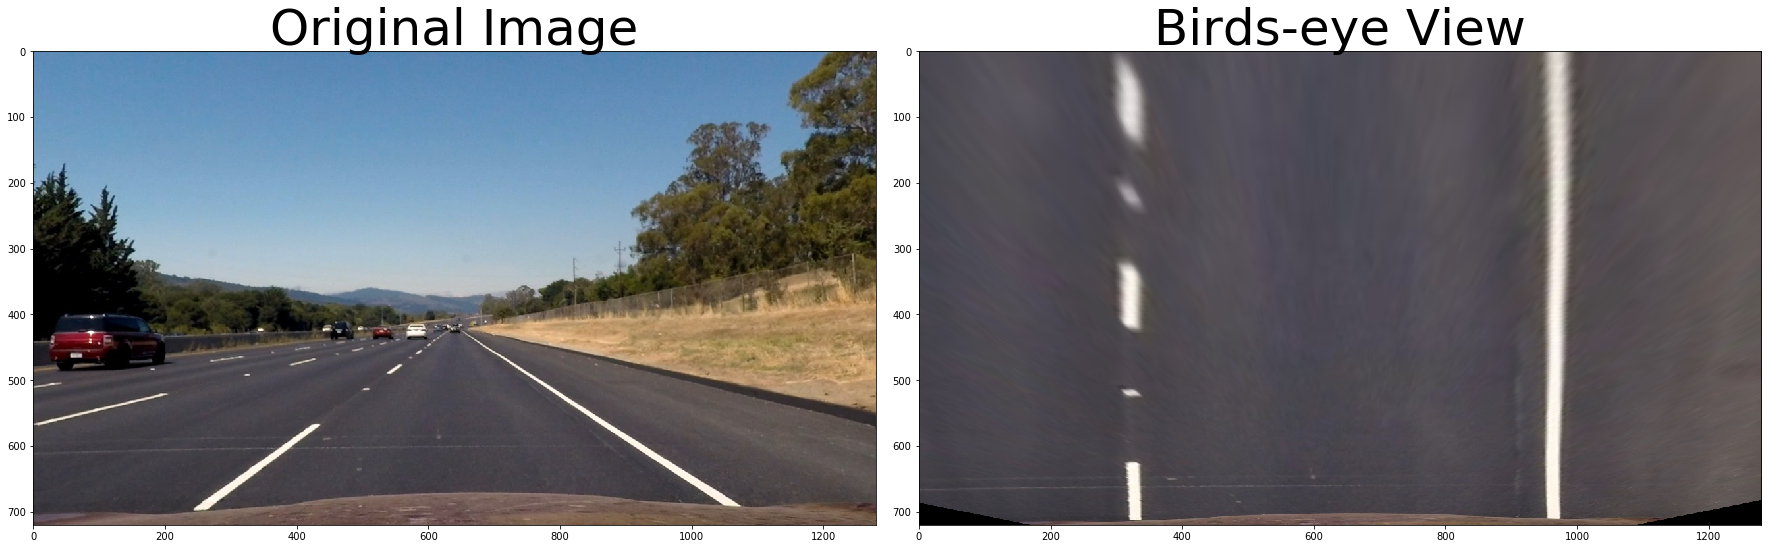

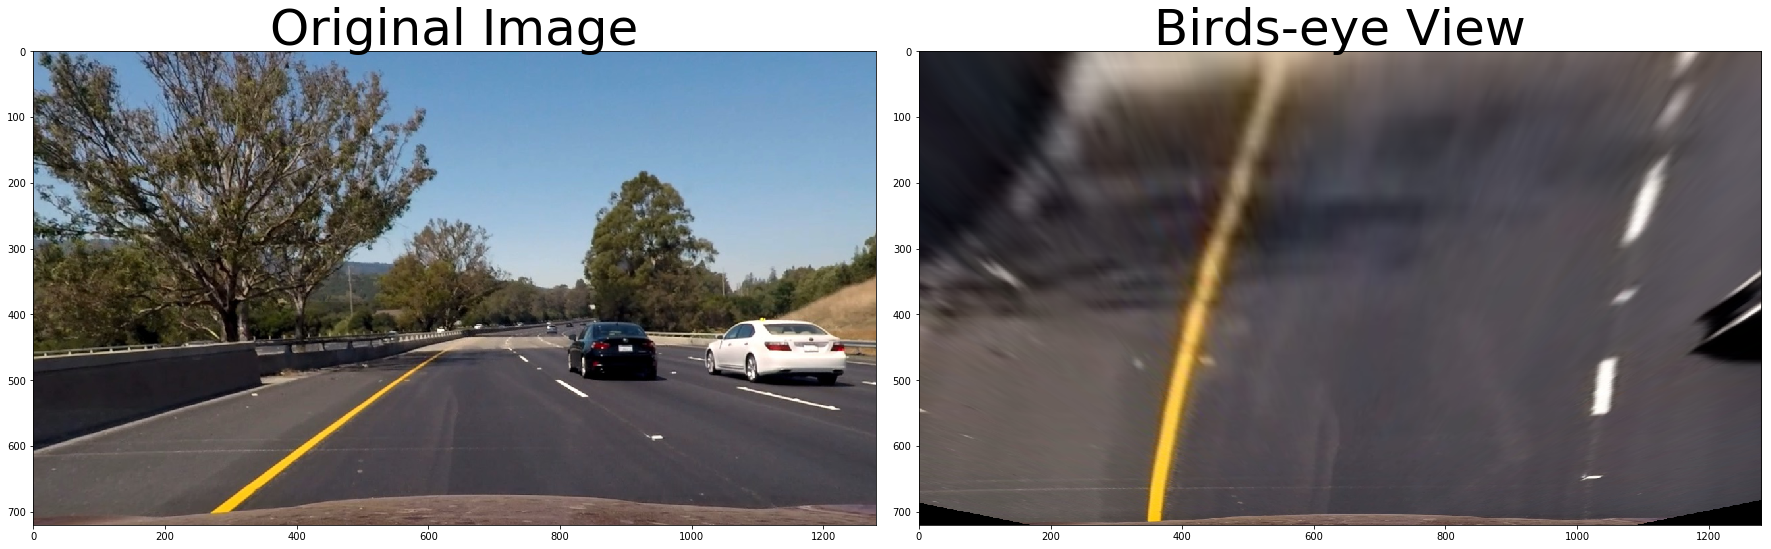

In [10]:
import glob
from pathlib import Path
from itertools import chain

for image_file in chain(glob.glob('test_images/straight_lines*.jpg'),('test_images/test6.jpg',)):
    perspective_example = cv2.undistort(mpimg.imread(image_file), mtx, dist, None, mtx)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))

    f.tight_layout()

    ax1.imshow(perspective_example)
    ax1.set_title('Original Image', fontsize=50)
    
    bird_view = bird_eye(perspective_example)
    mpimg.imsave(str(Path('output_birdview') / (Path(image_file).stem + '_birdview.png')), bird_view)
    ax2.imshow(bird_view)
    ax2.set_title('Birds-eye View', fontsize=50)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary.

In [11]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current+ margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(points_x, points_y, eval_x_at):

    ### Fit a second order polynomial to each using `np.polyfit` ###
    coefficients = np.polyfit(points_y, points_x, 2)

    try:
        x_at = np.polyval(coefficients, eval_x_at)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
    return x_at

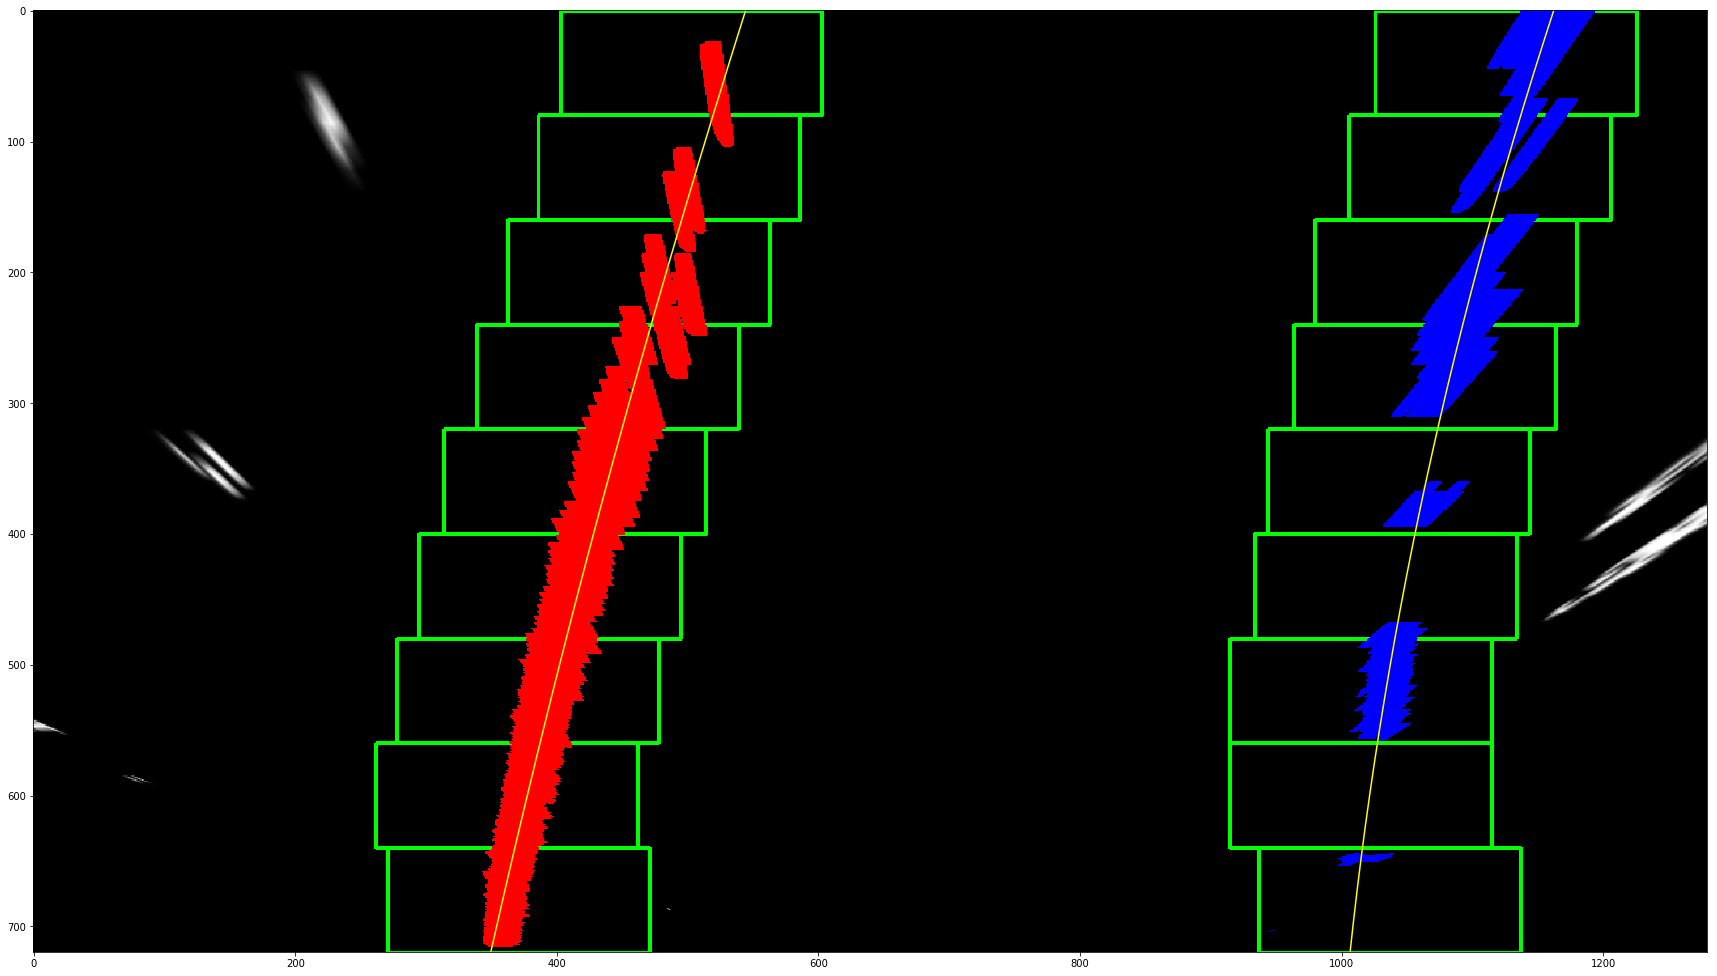

In [12]:
# Load our image
plt.figure(figsize=(30,20))
lane_pxs = pixels_threshold(mpimg.imread('test_images/test6.jpg'))
undist = cv2.undistort(lane_pxs, mtx, dist, None, mtx)
binary_warped = bird_eye(undist)

# Find our lane pixels first
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

# Generate x and y values for plotting
ploty = np.array(range(len(binary_warped)))
left_fitx= fit_polynomial(leftx, lefty, ploty)
right_fitx= fit_polynomial(rightx, righty, ploty)

## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')


plt.imshow(out_img)

## Determine the curvature of the lane and vehicle position with respect to center.

In [13]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 3.0/86 #30/720 # meters per pixel in y dimension
xm_per_pix = 3.7 / 872 *( 640 /(1104-207) ) #3.7/700 # meters per pixel in x dimension
a_to_m_per_pix = xm_per_pix / (ym_per_pix ** 2)
b_to_m_per_pix = xm_per_pix / ym_per_pix
def curvature_at_y(coefficients, y_at):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y = y_at * ym_per_pix
    a = a_to_m_per_pix * coefficients[0]
    b = b_to_m_per_pix * coefficients[1]
    
    return (1 + (2*a*y + b)**2)**1.5/np.abs(2*a)  ## Implement the calculation of the right line here
    

Car offset is 11cm
Left curvature is 342.5 at 719
Right curvature is 805.9 at 719


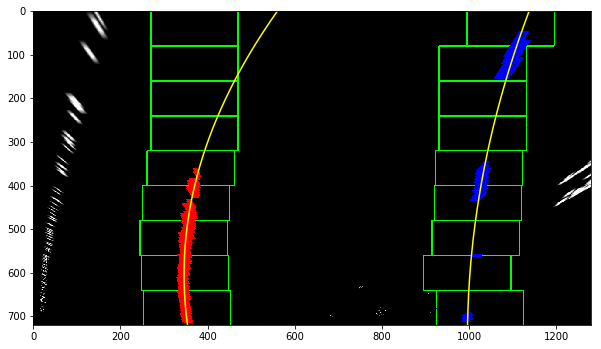

In [14]:
test_image = mpimg.imread('test_images/test1.jpg')
plt.figure(figsize=(10,20))
undist = cv2.undistort(test_image, mtx, dist, None, mtx)
lane_pxs = pixels_threshold(undist)
binary_warped = bird_eye(lane_pxs)
# Find our lane pixels first
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

# Generate x and y values for plotting
ploty = np.array(range(len(binary_warped)))

left_weights = 1.0/(len(binary_warped) - lefty)**0.5
left_coefficients = np.polyfit(lefty, leftx, 2, w = left_weights)
left_fitx = np.polyval(left_coefficients, ploty)

right_weights = 1.0/(len(binary_warped) - righty)**0.5
right_coefficients = np.polyfit(righty, rightx, 2, w = right_weights)
right_fitx = np.polyval(right_coefficients, ploty)

print("Car offset is {:.0f}cm".format(100*xm_per_pix*abs(binary_warped.shape[1] - (left_fitx[-1]+right_fitx[-1]))/2.0))
print("Left curvature is {:.1f} at {}".format(curvature_at_y(left_coefficients, ploty[-1]), ploty[-1]))
print("Right curvature is {:.1f} at {}".format(curvature_at_y(right_coefficients,  ploty[-1]),  ploty[-1]))

## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')


plt.imshow(out_img)

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

1200 700


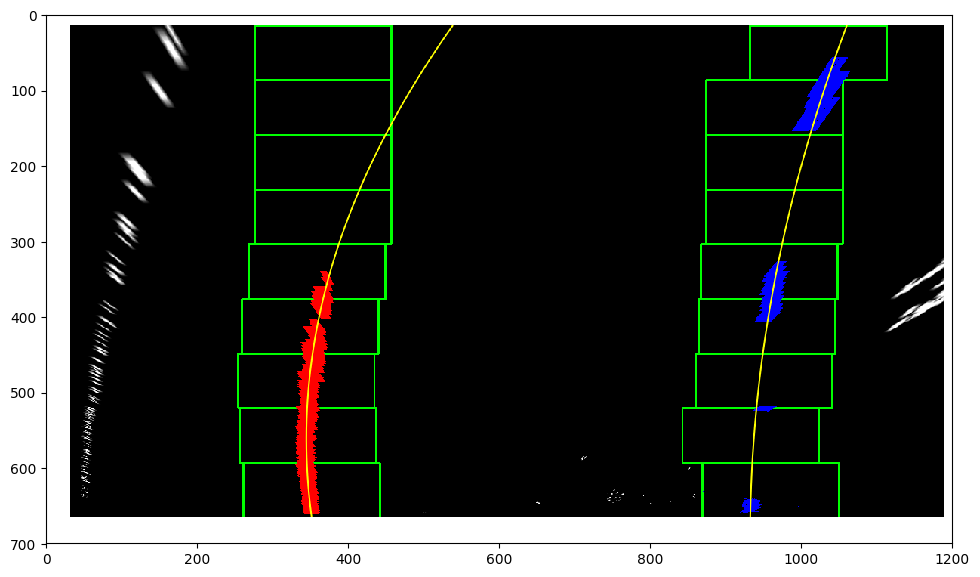

In [23]:
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ()
 
    # Get the RGB buffer from the figure
    h,w = fig.canvas.get_width_height()
    print(h,w)
    buf = np.frombuffer ( fig.canvas.tostring_rgb(), dtype=np.uint8 )
    buf.shape = ( w, h, 3 )
 
    return buf

def fitline_processing_pipeline(image):
    #Image from plot
    fig = plt.figure(figsize=tuple(np.array(np.array(image.shape[-2::-1])/100, dtype=np.int)), dpi = 100, frameon=False )
    ax = fig.gca()
    ax.axis('off')
    fig.tight_layout(pad=0)
    # To remove the huge white borders
    ax.margins(0)
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    lane_pxs = pixels_threshold(undist)
    binary_warped = bird_eye(lane_pxs)
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    if len(leftx) == 0 or len(rightx) == 0:
        return undist        

    # Generate x and y values for plotting
    ploty = np.array(range(len(binary_warped)))

    left_weights = 1.0/(len(binary_warped) - lefty)**0.5
    left_coefficients = np.polyfit(lefty, leftx, 2, w = left_weights)
    left_fitx = np.polyval(left_coefficients, ploty)

    right_weights = 1.0/(len(binary_warped) - righty)**0.5
    right_coefficients = np.polyfit(righty, rightx, 2, w = right_weights)
    right_fitx = np.polyval(right_coefficients, ploty)
        
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.imshow(out_img)    
    
    full_fig = fig2data(fig)
    plt.clf()
    plt.close(fig)
    
    return full_fig

In [18]:
font = cv2.FONT_HERSHEY_SIMPLEX

def image_processing_pipeline(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    lane_pxs = pixels_threshold(undist)
    binary_warped = bird_eye(lane_pxs)
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    if len(leftx) == 0 or len(rightx) == 0:
        return undist        

    # Generate x and y values for plotting
    ploty = np.array(range(len(binary_warped)))

    left_weights = 1.0/(len(binary_warped) - lefty)**0.5
    left_coefficients = np.polyfit(lefty, leftx, 2, w = left_weights)
    left_fitx = np.polyval(left_coefficients, ploty)

    right_weights = 1.0/(len(binary_warped) - righty)**0.5
    right_coefficients = np.polyfit(righty, rightx, 2, w = right_weights)
    right_fitx = np.polyval(right_coefficients, ploty)

    #Create an image to draw the lines on
    color_warp = np.zeros_like(test_image).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (test_image.shape[1], test_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    infos = (
        "Car offset is {:3.0f}cm".format(100*xm_per_pix*abs(binary_warped.shape[1] - (left_fitx[-1]+right_fitx[-1]))/2.0),
        "Left curvature is {:5.0f}m".format(curvature_at_y(left_coefficients, ploty[-1])),
        "Right curvature is {:5.0f}m".format(curvature_at_y(right_coefficients,  ploty[-1]))
    )
    text_height = 20
    for info in infos:
        (_, height), _ = cv2.getTextSize(info, font, 1, 4)
        text_height += height + 10
        cv2.putText(result, info, (20,text_height), font, 1, (255, 255, 255), 4)
    
    return result

### CellTest

import glob

image_list = list(glob.glob('test_images/*.jpg'))

f, subaxis = plt.subplots((len(image_list)+2)//3, 3, figsize=(24, 16))

f.tight_layout()
for image_file, ax in zip(image_list, subaxis.flatten()):
    ax.imshow(image_processing_pipeline(mpimg.imread(image_file)))

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Video Run

In [38]:
from collections import deque

# Define a class to receive the characteristics of each line detection
class ActivatedPixels:
    def __init__(self, at_x: np.array, at_y: np.array, bounds: tuple):
        self.at_x = at_x
        self.at_y = at_y
        self.bound = dict(zip('xy',bounds))
    
    @staticmethod
    def from_image(binary_image):
        nonzero = binary_warped.nonzero()
        return ActivatedPixels(np.array(nonzero[1]), np.array(nonzero[0]), binary_image.shape[1::-1])
        
class Line:
    def __init__(self):
        # was the line detected in the last iteration?
        self.skiped_frames = 0
        # x values of the last n fits of the line
        self.recent_coefficients = deque(maxlen=4)
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
    
    def update_lane_pixels(self, activated_pixels: ActivatedPixels):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 80

        lane_indexs = (np.abs(np.polyval(self.recent_coefficients[-1], activated_pixels.at_y) - activated_pixels.at_x) < margin).nonzero()

        # Again, extract left and right line pixel positions
        lanex = activated_pixels.at_x[lane_indexs]
        laney = activated_pixels.at_y[lane_indexs] 

        # Fit new polynomials
        ### Fit a second order polynomial to each using `np.polyfit` ###
        try:
            self.recent_coefficients.append(np.polyfit(laney, lanex, 2))
            
        except TypeError:

#         lane_fitx = np.polyval(coefficients, y_range)

        return coefficients, lane_fitx
    
    @staticmethod
    def find_lane_pixels(binary_warped, activated_pixels):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(activated_pixels.bound['y']//nwindows)
        
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - margin  # Update this
            win_xleft_high = leftx_current + margin  # Update this
            win_xright_low = rightx_current - margin  # Update this
            win_xright_high = rightx_current+ margin  # Update this

            ### Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((activated_pixels.at_y >= win_y_low) & (activated_pixels.at_y < win_y_high) & 
            (activated_pixels.at_x >= win_xleft_low) &  (activated_pixels.at_x < win_xleft_high)).nonzero()[0]
            good_right_inds = ((activated_pixels.at_y >= win_y_low) & (activated_pixels.at_y < win_y_high) & 
            (activated_pixels.at_x >= win_xright_low) &  (activated_pixels.at_x < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            ### (`right` or `leftx_current`) on their mean position ###
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(activated_pixels.at_x[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(activated_pixels.at_x[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = activated_pixels.at_x[left_lane_inds]
        lefty = activated_pixels.at_y[left_lane_inds] 
        rightx = activated_pixels.at_x[right_lane_inds]
        righty = activated_pixels.at_y[right_lane_inds]
        
        try:
            left_coefficients = np.polyfit(lefty, leftx, 2)
        except TypeError:
            left_coefficients = None
        try:
            right_coefficients = np.polyfit(righty, rightx, 2)
        except TypeError:
            right_coefficients = None

        return left_coefficients, right_coefficients

In [ ]:
class LaneTraker:
    def __init__(self):
        self.lanes = {'left': Line(), 'right': Line()}
        
    def process_video_frame(self, frame):
        ## Pre-processing
        undist = cv2.undistort(frame, mtx, dist, None, mtx)
        lane_pxs = pixels_threshold(undist)
        binary_warped = bird_eye(lane_pxs)
        activated_pixels = ActivatedPixels.from_image(binary_warped)

        # Find our lane pixels first
        y_range = np.array(range(len(binary_warped)))
        for lane in self.lanes.values():
            try:
                coefficients, lane_fitx = update_lane_pixels(activated_pixels , old_coefficients, y_range)
            except TypeError:
                pass
        
        
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
        if len(leftx) == 0 or len(rightx) == 0:
            return undist        

        # Generate x and y values for plotting
        ploty = np.array(range(len(binary_warped)))

        left_weights = 1.0/(len(binary_warped) - lefty)**0.5
        left_coefficients = np.polyfit(lefty, leftx, 2, w = left_weights)
        left_fitx = np.polyval(left_coefficients, ploty)

        right_weights = 1.0/(len(binary_warped) - righty)**0.5
        right_coefficients = np.polyfit(righty, rightx, 2, w = right_weights)
        right_fitx = np.polyval(right_coefficients, ploty)

        #Create an image to draw the lines on
        color_warp = np.zeros_like(test_image).astype(np.uint8)

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (test_image.shape[1], test_image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

        infos = (
            "Car offset is {:3.0f}cm".format(100*xm_per_pix*abs(binary_warped.shape[1] - (left_fitx[-1]+right_fitx[-1]))/2.0),
            "Left curvature is {:5.0f}m".format(curvature_at_y(left_coefficients, ploty[-1])),
            "Right curvature is {:5.0f}m".format(curvature_at_y(right_coefficients,  ploty[-1]))
        )
        text_height = 20
        for info in infos:
            (_, height), _ = cv2.getTextSize(info, font, 1, 4)
            text_height += height + 10
            cv2.putText(result, info, (20,text_height), font, 1, (255, 255, 255), 4)

        return result

In [35]:
class ActivatedPixels:
    def __init__(self, binary_image):
        self.at_x = np.array([])
        self.at_y = np.array([])
        
    def from_image(self, binary_image)
        nonzero = binary_warped.nonzero()
        self.at_y = np.array(nonzero[0])
        self.at_x = np.array(nonzero[1])



def update_lane_pixels(activated_pixels: ActivatedPixels , old_coefficients: np.array, y_range):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 80
    
    lane_indexs = (np.abs(np.polyval(old_coefficients, activated_pixels.at_y) - activated_pixels.at_x) < margin).nonzero()
    
    # Again, extract left and right line pixel positions
    lanex = activated_pixels.at_x[lane_indexs]
    laney = activated_pixels.at_y[lane_indexs] 

    # Fit new polynomials
    ### Fit a second order polynomial to each using `np.polyfit` ###
    coefficients = np.polyfit(laney, lanex, 2)

    lane_fitx = np.polyval(coefficients, y_range)
        
    return coefficients, lane_fitx

In [ ]:
def draw_visualization(binary_warped):    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Automatic pdb calling has been turned ON
1200 700
[MoviePy] >>>> Building video output_videos/birdview_challenge_video.mp4
[MoviePy] Writing video output_videos/birdview_challenge_video.mp4


  0%|          | 1/485 [00:00<03:48,  2.12it/s]

1200 700


  0%|          | 2/485 [00:00<03:43,  2.17it/s]

1200 700


  1%|          | 3/485 [00:01<03:25,  2.35it/s]

1200 700


  1%|          | 4/485 [00:01<03:13,  2.49it/s]

1200 700


  1%|          | 5/485 [00:01<02:59,  2.67it/s]

1200 700


  1%|          | 6/485 [00:02<02:51,  2.79it/s]

1200 700


  1%|▏         | 7/485 [00:02<02:53,  2.76it/s]

1200 700


  2%|▏         | 8/485 [00:02<02:47,  2.84it/s]

1200 700


  2%|▏         | 9/485 [00:03<02:56,  2.69it/s]

1200 700


  2%|▏         | 10/485 [00:03<02:58,  2.66it/s]

1200 700


  2%|▏         | 11/485 [00:04<02:54,  2.71it/s]

1200 700


  2%|▏         | 12/485 [00:04<02:56,  2.68it/s]

1200 700


  3%|▎         | 13/485 [00:04<02:55,  2.68it/s]

1200 700


  3%|▎         | 14/485 [00:05<02:57,  2.66it/s]

1200 700


  3%|▎         | 15/485 [00:05<02:53,  2.71it/s]

1200 700


  3%|▎         | 16/485 [00:05<02:48,  2.79it/s]

1200 700


  4%|▎         | 17/485 [00:06<02:42,  2.88it/s]

1200 700


  4%|▎         | 18/485 [00:06<02:41,  2.90it/s]

1200 700


  4%|▍         | 19/485 [00:06<02:37,  2.96it/s]

1200 700


  4%|▍         | 20/485 [00:07<02:38,  2.94it/s]

1200 700


  4%|▍         | 21/485 [00:07<02:38,  2.93it/s]

1200 700


  5%|▍         | 22/485 [00:08<02:49,  2.73it/s]

1200 700


  5%|▍         | 23/485 [00:08<02:45,  2.79it/s]

1200 700


  5%|▍         | 24/485 [00:08<02:46,  2.77it/s]

1200 700


  5%|▌         | 25/485 [00:09<02:44,  2.79it/s]

1200 700


  5%|▌         | 26/485 [00:09<02:40,  2.86it/s]

1200 700


  6%|▌         | 27/485 [00:09<02:37,  2.90it/s]

1200 700


  6%|▌         | 28/485 [00:10<02:37,  2.90it/s]

1200 700


  6%|▌         | 29/485 [00:10<02:43,  2.79it/s]

1200 700


  6%|▌         | 30/485 [00:10<02:47,  2.72it/s]

1200 700


  6%|▋         | 31/485 [00:11<02:46,  2.73it/s]

1200 700


  7%|▋         | 32/485 [00:11<02:44,  2.75it/s]

1200 700


  7%|▋         | 33/485 [00:11<02:41,  2.80it/s]

1200 700


  7%|▋         | 34/485 [00:12<02:42,  2.78it/s]

1200 700


  7%|▋         | 35/485 [00:12<02:53,  2.60it/s]

1200 700


  7%|▋         | 36/485 [00:13<03:02,  2.47it/s]

1200 700


  8%|▊         | 37/485 [00:13<02:57,  2.53it/s]

1200 700


  8%|▊         | 38/485 [00:13<02:49,  2.64it/s]

1200 700


  8%|▊         | 39/485 [00:14<02:44,  2.71it/s]

1200 700


  8%|▊         | 40/485 [00:14<02:45,  2.68it/s]

1200 700


  8%|▊         | 41/485 [00:14<02:42,  2.74it/s]

1200 700


  9%|▊         | 42/485 [00:15<02:39,  2.78it/s]

1200 700


  9%|▉         | 43/485 [00:15<02:41,  2.74it/s]

1200 700


  9%|▉         | 44/485 [00:16<02:43,  2.70it/s]

1200 700


  9%|▉         | 45/485 [00:16<02:44,  2.67it/s]

1200 700


  9%|▉         | 46/485 [00:16<02:50,  2.58it/s]

1200 700


 10%|▉         | 47/485 [00:17<02:48,  2.60it/s]

1200 700


 10%|▉         | 48/485 [00:17<02:47,  2.61it/s]

1200 700


 10%|█         | 49/485 [00:18<02:57,  2.45it/s]

1200 700


 10%|█         | 50/485 [00:18<02:51,  2.54it/s]

1200 700


 11%|█         | 51/485 [00:18<02:46,  2.60it/s]

1200 700


 11%|█         | 52/485 [00:19<02:40,  2.69it/s]

1200 700


 11%|█         | 53/485 [00:19<02:37,  2.74it/s]

1200 700


 11%|█         | 54/485 [00:19<02:36,  2.76it/s]

1200 700


 11%|█▏        | 55/485 [00:20<02:38,  2.71it/s]

1200 700


 12%|█▏        | 56/485 [00:20<02:35,  2.76it/s]

1200 700


 12%|█▏        | 57/485 [00:20<02:32,  2.80it/s]

1200 700


 12%|█▏        | 58/485 [00:21<02:29,  2.86it/s]

1200 700


 12%|█▏        | 59/485 [00:21<02:27,  2.89it/s]

1200 700


 12%|█▏        | 60/485 [00:21<02:26,  2.90it/s]

1200 700


 13%|█▎        | 61/485 [00:22<02:26,  2.89it/s]

1200 700


 13%|█▎        | 62/485 [00:22<02:33,  2.76it/s]

1200 700


 13%|█▎        | 63/485 [00:23<02:45,  2.55it/s]

1200 700


 13%|█▎        | 64/485 [00:23<02:42,  2.59it/s]

1200 700


 13%|█▎        | 65/485 [00:23<02:37,  2.66it/s]

1200 700


 14%|█▎        | 66/485 [00:24<02:35,  2.69it/s]

1200 700


 14%|█▍        | 67/485 [00:24<02:40,  2.61it/s]

1200 700


 14%|█▍        | 68/485 [00:25<02:39,  2.62it/s]

1200 700


 14%|█▍        | 69/485 [00:25<02:34,  2.70it/s]

1200 700


 14%|█▍        | 70/485 [00:25<02:30,  2.76it/s]

1200 700


 15%|█▍        | 71/485 [00:26<02:27,  2.81it/s]

1200 700


 15%|█▍        | 72/485 [00:26<02:29,  2.76it/s]

1200 700


 15%|█▌        | 73/485 [00:26<02:26,  2.82it/s]

1200 700


 15%|█▌        | 74/485 [00:27<02:26,  2.80it/s]

1200 700


 15%|█▌        | 75/485 [00:27<02:24,  2.84it/s]

1200 700


 16%|█▌        | 76/485 [00:27<02:24,  2.83it/s]

1200 700


 16%|█▌        | 77/485 [00:28<02:34,  2.64it/s]

1200 700


 16%|█▌        | 78/485 [00:28<02:30,  2.70it/s]

1200 700


 16%|█▋        | 79/485 [00:28<02:28,  2.73it/s]

1200 700


 16%|█▋        | 80/485 [00:29<02:28,  2.73it/s]

1200 700


 17%|█▋        | 81/485 [00:29<02:27,  2.74it/s]

1200 700


 17%|█▋        | 82/485 [00:30<02:27,  2.72it/s]

1200 700


 17%|█▋        | 83/485 [00:30<02:24,  2.78it/s]

1200 700


 17%|█▋        | 84/485 [00:30<02:22,  2.81it/s]

1200 700


 18%|█▊        | 85/485 [00:31<02:20,  2.85it/s]

1200 700


 18%|█▊        | 86/485 [00:31<02:22,  2.80it/s]

1200 700


 18%|█▊        | 87/485 [00:31<02:23,  2.77it/s]

1200 700


 18%|█▊        | 88/485 [00:32<02:23,  2.77it/s]

1200 700


 18%|█▊        | 89/485 [00:32<02:22,  2.78it/s]

1200 700


 19%|█▊        | 90/485 [00:32<02:19,  2.83it/s]

1200 700


 19%|█▉        | 91/485 [00:33<02:30,  2.61it/s]

1200 700


 19%|█▉        | 92/485 [00:33<02:26,  2.69it/s]

1200 700


 19%|█▉        | 93/485 [00:34<02:21,  2.76it/s]

1200 700


 19%|█▉        | 94/485 [00:34<02:18,  2.81it/s]

1200 700


 20%|█▉        | 95/485 [00:34<02:16,  2.85it/s]

1200 700


 20%|█▉        | 96/485 [00:35<02:16,  2.85it/s]

1200 700


 20%|██        | 97/485 [00:35<02:14,  2.89it/s]

1200 700


 20%|██        | 98/485 [00:35<02:14,  2.87it/s]

1200 700


 20%|██        | 99/485 [00:36<02:13,  2.88it/s]

1200 700


 21%|██        | 100/485 [00:36<02:22,  2.70it/s]

1200 700


 21%|██        | 101/485 [00:36<02:20,  2.73it/s]

1200 700


 21%|██        | 102/485 [00:37<02:21,  2.72it/s]

1200 700


 21%|██        | 103/485 [00:37<02:19,  2.74it/s]

1200 700


 21%|██▏       | 104/485 [00:38<02:21,  2.69it/s]

1200 700


 22%|██▏       | 105/485 [00:38<02:27,  2.57it/s]

1200 700


 22%|██▏       | 106/485 [00:38<02:21,  2.68it/s]

1200 700


 22%|██▏       | 107/485 [00:39<02:22,  2.66it/s]

1200 700


 22%|██▏       | 108/485 [00:39<02:17,  2.73it/s]

1200 700


 22%|██▏       | 109/485 [00:39<02:17,  2.74it/s]

1200 700


 23%|██▎       | 110/485 [00:40<02:13,  2.82it/s]

1200 700


 23%|██▎       | 111/485 [00:40<02:13,  2.80it/s]

1200 700


 23%|██▎       | 112/485 [00:40<02:12,  2.81it/s]

1200 700


 23%|██▎       | 113/485 [00:41<02:12,  2.80it/s]

1200 700


 24%|██▎       | 114/485 [00:41<02:13,  2.78it/s]

1200 700


 24%|██▎       | 115/485 [00:41<02:12,  2.80it/s]

1200 700


 24%|██▍       | 116/485 [00:42<02:16,  2.70it/s]

1200 700


 24%|██▍       | 117/485 [00:42<02:21,  2.60it/s]

1200 700


 24%|██▍       | 118/485 [00:43<02:23,  2.55it/s]

1200 700


 25%|██▍       | 119/485 [00:43<02:21,  2.58it/s]

1200 700


 25%|██▍       | 120/485 [00:44<02:27,  2.47it/s]

1200 700


 25%|██▍       | 121/485 [00:44<02:21,  2.57it/s]

1200 700


 25%|██▌       | 122/485 [00:44<02:20,  2.59it/s]

1200 700


 25%|██▌       | 123/485 [00:45<02:18,  2.61it/s]

1200 700


 26%|██▌       | 124/485 [00:45<02:18,  2.62it/s]

1200 700


 26%|██▌       | 125/485 [00:45<02:16,  2.64it/s]

1200 700


 26%|██▌       | 126/485 [00:46<02:16,  2.63it/s]

1200 700


 26%|██▌       | 127/485 [00:46<02:17,  2.61it/s]

1200 700


 26%|██▋       | 128/485 [00:47<02:15,  2.64it/s]

1200 700


 27%|██▋       | 129/485 [00:47<02:12,  2.69it/s]

1200 700


 27%|██▋       | 130/485 [00:47<02:09,  2.74it/s]

1200 700


 27%|██▋       | 131/485 [00:48<02:08,  2.76it/s]

1200 700


 27%|██▋       | 132/485 [00:48<02:12,  2.67it/s]

1200 700


 27%|██▋       | 133/485 [00:48<02:12,  2.65it/s]

1200 700


 28%|██▊       | 134/485 [00:49<02:13,  2.63it/s]

1200 700


 28%|██▊       | 136/485 [00:50<02:16,  2.56it/s]

1200 700


 28%|██▊       | 137/485 [00:50<02:14,  2.58it/s]

1200 700


 28%|██▊       | 138/485 [00:50<02:24,  2.39it/s]

1200 700


 29%|██▊       | 139/485 [00:51<02:25,  2.38it/s]

1200 700


 29%|██▉       | 140/485 [00:51<02:23,  2.40it/s]

1200 700


 29%|██▉       | 141/485 [00:52<02:22,  2.41it/s]

1200 700


 29%|██▉       | 142/485 [00:52<02:21,  2.43it/s]

1200 700


 29%|██▉       | 143/485 [00:52<02:19,  2.46it/s]

1200 700


 30%|██▉       | 144/485 [00:53<02:17,  2.49it/s]

1200 700


 30%|██▉       | 145/485 [00:53<02:15,  2.52it/s]

1200 700


 30%|███       | 146/485 [00:54<02:15,  2.50it/s]

1200 700


 30%|███       | 147/485 [00:54<02:14,  2.51it/s]

1200 700


 31%|███       | 148/485 [00:54<02:14,  2.51it/s]

1200 700


 31%|███       | 149/485 [00:55<02:23,  2.34it/s]

1200 700


 31%|███       | 150/485 [00:55<02:23,  2.33it/s]

1200 700


 31%|███       | 151/485 [00:56<02:19,  2.39it/s]

1200 700


 31%|███▏      | 152/485 [00:56<02:17,  2.42it/s]

1200 700


 32%|███▏      | 153/485 [00:57<02:15,  2.45it/s]

1200 700


 32%|███▏      | 154/485 [00:57<02:15,  2.45it/s]

1200 700


 32%|███▏      | 155/485 [00:57<02:16,  2.42it/s]

1200 700


 32%|███▏      | 156/485 [00:58<02:14,  2.45it/s]

1200 700


 32%|███▏      | 157/485 [00:58<02:13,  2.47it/s]

1200 700


 33%|███▎      | 158/485 [00:59<02:11,  2.48it/s]

1200 700


 33%|███▎      | 159/485 [00:59<02:11,  2.47it/s]

1200 700


 33%|███▎      | 160/485 [00:59<02:12,  2.45it/s]

1200 700


 33%|███▎      | 161/485 [01:00<02:12,  2.45it/s]

1200 700


 33%|███▎      | 162/485 [01:00<02:11,  2.46it/s]

1200 700


 34%|███▎      | 163/485 [01:01<02:12,  2.42it/s]

1200 700


 34%|███▍      | 164/485 [01:01<02:12,  2.42it/s]

1200 700


 34%|███▍      | 165/485 [01:02<02:19,  2.29it/s]

1200 700


 34%|███▍      | 166/485 [01:02<02:17,  2.32it/s]

1200 700


 34%|███▍      | 167/485 [01:02<02:15,  2.35it/s]

1200 700


 35%|███▍      | 168/485 [01:03<02:10,  2.42it/s]

1200 700


 35%|███▍      | 169/485 [01:03<02:08,  2.45it/s]

1200 700


 35%|███▌      | 170/485 [01:04<02:08,  2.45it/s]

1200 700


 35%|███▌      | 171/485 [01:04<02:06,  2.49it/s]

1200 700


 35%|███▌      | 172/485 [01:04<02:05,  2.49it/s]

1200 700


 36%|███▌      | 173/485 [01:05<02:05,  2.49it/s]

1200 700


 36%|███▌      | 174/485 [01:05<02:03,  2.52it/s]

1200 700


 36%|███▌      | 175/485 [01:06<02:01,  2.56it/s]

1200 700


 36%|███▋      | 176/485 [01:06<02:00,  2.57it/s]

1200 700


 36%|███▋      | 177/485 [01:06<01:58,  2.59it/s]

1200 700


 37%|███▋      | 178/485 [01:07<01:59,  2.57it/s]

1200 700


 37%|███▋      | 179/485 [01:07<01:59,  2.56it/s]

1200 700


 37%|███▋      | 180/485 [01:07<01:58,  2.58it/s]

1200 700


 37%|███▋      | 181/485 [01:08<02:05,  2.43it/s]

1200 700


 38%|███▊      | 182/485 [01:08<02:02,  2.47it/s]

1200 700


 38%|███▊      | 183/485 [01:09<02:00,  2.51it/s]

1200 700


 38%|███▊      | 184/485 [01:09<01:56,  2.58it/s]

1200 700


 38%|███▊      | 185/485 [01:09<01:56,  2.58it/s]

1200 700


 38%|███▊      | 186/485 [01:10<01:55,  2.60it/s]

1200 700


 39%|███▊      | 187/485 [01:10<01:53,  2.62it/s]

1200 700


 39%|███▉      | 188/485 [01:11<01:52,  2.64it/s]

1200 700


 39%|███▉      | 189/485 [01:11<01:50,  2.68it/s]

1200 700


 39%|███▉      | 190/485 [01:11<01:49,  2.68it/s]

1200 700


 39%|███▉      | 191/485 [01:12<01:48,  2.71it/s]

1200 700


 40%|███▉      | 192/485 [01:12<01:48,  2.69it/s]

1200 700


 40%|███▉      | 193/485 [01:12<01:47,  2.72it/s]

1200 700


 40%|████      | 194/485 [01:13<01:46,  2.74it/s]

1200 700


 40%|████      | 195/485 [01:13<01:46,  2.73it/s]

1200 700


 40%|████      | 196/485 [01:14<01:47,  2.70it/s]

1200 700


 41%|████      | 197/485 [01:14<01:54,  2.51it/s]

1200 700


 41%|████      | 198/485 [01:14<01:52,  2.55it/s]

1200 700


 41%|████      | 199/485 [01:15<01:50,  2.60it/s]

1200 700


 41%|████      | 200/485 [01:15<01:50,  2.58it/s]

1200 700


 41%|████▏     | 201/485 [01:16<01:48,  2.61it/s]

1200 700


 42%|████▏     | 202/485 [01:16<01:49,  2.58it/s]

1200 700


 42%|████▏     | 203/485 [01:16<01:49,  2.58it/s]

1200 700


 42%|████▏     | 204/485 [01:17<01:46,  2.63it/s]

1200 700


 42%|████▏     | 205/485 [01:17<01:45,  2.65it/s]

1200 700


 42%|████▏     | 206/485 [01:17<01:45,  2.64it/s]

1200 700


 43%|████▎     | 207/485 [01:18<01:44,  2.66it/s]

1200 700


 43%|████▎     | 208/485 [01:18<01:43,  2.67it/s]

1200 700


 43%|████▎     | 209/485 [01:19<01:42,  2.69it/s]

1200 700


 43%|████▎     | 210/485 [01:19<01:41,  2.70it/s]

1200 700


 44%|████▎     | 211/485 [01:19<01:40,  2.72it/s]

1200 700


 44%|████▎     | 212/485 [01:20<01:42,  2.65it/s]

1200 700


 44%|████▍     | 213/485 [01:20<01:52,  2.42it/s]

1200 700


 44%|████▍     | 214/485 [01:21<01:48,  2.50it/s]

1200 700


 44%|████▍     | 215/485 [01:21<01:48,  2.50it/s]

1200 700


 45%|████▍     | 216/485 [01:21<01:48,  2.48it/s]

1200 700


 45%|████▍     | 217/485 [01:22<01:48,  2.48it/s]

1200 700


 45%|████▍     | 218/485 [01:22<01:45,  2.52it/s]

1200 700


 45%|████▌     | 219/485 [01:22<01:43,  2.56it/s]

1200 700


 45%|████▌     | 220/485 [01:23<01:43,  2.56it/s]

1200 700


 46%|████▌     | 221/485 [01:23<01:44,  2.53it/s]

1200 700


 46%|████▌     | 222/485 [01:24<01:45,  2.49it/s]

1200 700


 46%|████▌     | 223/485 [01:24<01:45,  2.49it/s]

1200 700


 46%|████▌     | 224/485 [01:25<01:46,  2.46it/s]

1200 700


 46%|████▋     | 225/485 [01:25<01:44,  2.49it/s]

1200 700


 47%|████▋     | 226/485 [01:25<01:46,  2.44it/s]

1200 700


 47%|████▋     | 227/485 [01:26<01:43,  2.48it/s]

1200 700


 47%|████▋     | 228/485 [01:26<01:42,  2.52it/s]

1200 700


 47%|████▋     | 229/485 [01:27<01:42,  2.50it/s]

1200 700


 47%|████▋     | 230/485 [01:27<01:48,  2.35it/s]

1200 700


 48%|████▊     | 231/485 [01:27<01:46,  2.38it/s]

1200 700


 48%|████▊     | 232/485 [01:28<01:46,  2.38it/s]

1200 700


 48%|████▊     | 233/485 [01:28<01:45,  2.38it/s]

1200 700


 48%|████▊     | 234/485 [01:29<01:49,  2.30it/s]

1200 700


 48%|████▊     | 235/485 [01:29<01:48,  2.29it/s]

1200 700


 49%|████▊     | 236/485 [01:30<01:47,  2.32it/s]

1200 700


 49%|████▉     | 237/485 [01:30<01:45,  2.34it/s]

1200 700


 49%|████▉     | 238/485 [01:30<01:44,  2.36it/s]

1200 700


 49%|████▉     | 239/485 [01:31<01:42,  2.40it/s]

1200 700


 49%|████▉     | 240/485 [01:31<01:38,  2.48it/s]

1200 700


 50%|████▉     | 241/485 [01:32<01:36,  2.54it/s]

1200 700


 50%|████▉     | 242/485 [01:32<01:37,  2.50it/s]

1200 700


 50%|█████     | 243/485 [01:32<01:36,  2.49it/s]

1200 700


 50%|█████     | 244/485 [01:33<01:37,  2.47it/s]

1200 700


 51%|█████     | 245/485 [01:33<01:36,  2.48it/s]

1200 700


 51%|█████     | 246/485 [01:34<01:35,  2.50it/s]

1200 700


 51%|█████     | 247/485 [01:34<01:42,  2.32it/s]

1200 700


 51%|█████     | 248/485 [01:35<01:42,  2.30it/s]

1200 700


 51%|█████▏    | 249/485 [01:35<01:40,  2.35it/s]

1200 700


 52%|█████▏    | 250/485 [01:35<01:38,  2.40it/s]

1200 700


 52%|█████▏    | 251/485 [01:36<01:36,  2.43it/s]

1200 700


 52%|█████▏    | 252/485 [01:36<01:34,  2.47it/s]

1200 700


 52%|█████▏    | 253/485 [01:37<01:32,  2.52it/s]

1200 700


 52%|█████▏    | 254/485 [01:37<01:31,  2.54it/s]

1200 700


 53%|█████▎    | 255/485 [01:37<01:29,  2.56it/s]

1200 700


 53%|█████▎    | 256/485 [01:38<01:30,  2.52it/s]

1200 700


 53%|█████▎    | 257/485 [01:38<01:31,  2.49it/s]

1200 700


 53%|█████▎    | 258/485 [01:38<01:30,  2.51it/s]

1200 700


 53%|█████▎    | 259/485 [01:39<01:27,  2.57it/s]

1200 700


 54%|█████▎    | 260/485 [01:39<01:28,  2.53it/s]

1200 700


 54%|█████▍    | 261/485 [01:40<01:29,  2.51it/s]

1200 700


 54%|█████▍    | 262/485 [01:40<01:28,  2.53it/s]

1200 700


 54%|█████▍    | 263/485 [01:40<01:27,  2.54it/s]

1200 700


 54%|█████▍    | 264/485 [01:41<01:32,  2.39it/s]

1200 700


 55%|█████▍    | 265/485 [01:41<01:28,  2.48it/s]

1200 700


 55%|█████▍    | 266/485 [01:42<01:25,  2.55it/s]

1200 700


 55%|█████▌    | 267/485 [01:42<01:26,  2.53it/s]

1200 700


 55%|█████▌    | 268/485 [01:42<01:24,  2.58it/s]

1200 700


 55%|█████▌    | 269/485 [01:43<01:24,  2.56it/s]

1200 700


 56%|█████▌    | 270/485 [01:43<01:24,  2.55it/s]

1200 700


 56%|█████▌    | 271/485 [01:44<01:23,  2.57it/s]

1200 700


 56%|█████▌    | 272/485 [01:44<01:22,  2.57it/s]

1200 700


 56%|█████▋    | 273/485 [01:44<01:23,  2.55it/s]

1200 700


 56%|█████▋    | 274/485 [01:45<01:22,  2.55it/s]

1200 700


 57%|█████▋    | 275/485 [01:45<01:22,  2.56it/s]

1200 700


 57%|█████▋    | 276/485 [01:46<01:21,  2.56it/s]

1200 700


 57%|█████▋    | 277/485 [01:46<01:21,  2.55it/s]

1200 700


 57%|█████▋    | 278/485 [01:46<01:23,  2.49it/s]

1200 700


 58%|█████▊    | 279/485 [01:47<01:25,  2.42it/s]

1200 700


 58%|█████▊    | 280/485 [01:47<01:24,  2.42it/s]

1200 700


 58%|█████▊    | 281/485 [01:48<01:32,  2.21it/s]

1200 700


 58%|█████▊    | 282/485 [01:48<01:28,  2.28it/s]

1200 700


 58%|█████▊    | 283/485 [01:49<01:35,  2.10it/s]

1200 700


 59%|█████▊    | 284/485 [01:49<01:32,  2.16it/s]

1200 700


 59%|█████▉    | 285/485 [01:50<01:29,  2.24it/s]

1200 700


 59%|█████▉    | 286/485 [01:50<01:25,  2.34it/s]

1200 700


 59%|█████▉    | 287/485 [01:50<01:21,  2.43it/s]

1200 700


 59%|█████▉    | 288/485 [01:51<01:18,  2.50it/s]

1200 700


 60%|█████▉    | 289/485 [01:51<01:16,  2.58it/s]

1200 700


 60%|█████▉    | 290/485 [01:51<01:14,  2.60it/s]

1200 700


 60%|██████    | 291/485 [01:52<01:13,  2.63it/s]

1200 700


 60%|██████    | 292/485 [01:52<01:12,  2.66it/s]

1200 700


 60%|██████    | 293/485 [01:53<01:11,  2.69it/s]

1200 700


 61%|██████    | 294/485 [01:53<01:11,  2.68it/s]

1200 700


 61%|██████    | 295/485 [01:53<01:10,  2.70it/s]

1200 700


 61%|██████    | 296/485 [01:54<01:10,  2.67it/s]

1200 700


 61%|██████    | 297/485 [01:54<01:11,  2.65it/s]

1200 700


 61%|██████▏   | 298/485 [01:55<01:17,  2.42it/s]

1200 700


 62%|██████▏   | 299/485 [01:55<01:14,  2.50it/s]

1200 700


 62%|██████▏   | 300/485 [01:55<01:13,  2.52it/s]

1200 700


 62%|██████▏   | 301/485 [01:56<01:11,  2.58it/s]

1200 700


 62%|██████▏   | 302/485 [01:56<01:09,  2.62it/s]

1200 700


 62%|██████▏   | 303/485 [01:56<01:09,  2.60it/s]

1200 700


 63%|██████▎   | 304/485 [01:57<01:15,  2.39it/s]

1200 700


 63%|██████▎   | 305/485 [01:57<01:15,  2.40it/s]

1200 700


 63%|██████▎   | 306/485 [01:58<01:14,  2.40it/s]

1200 700


 63%|██████▎   | 307/485 [01:58<01:12,  2.47it/s]

1200 700


 64%|██████▎   | 308/485 [01:59<01:10,  2.51it/s]

1200 700


 64%|██████▎   | 309/485 [01:59<01:08,  2.58it/s]

1200 700


 64%|██████▍   | 310/485 [01:59<01:06,  2.63it/s]

1200 700


 64%|██████▍   | 311/485 [02:00<01:05,  2.66it/s]

1200 700


 64%|██████▍   | 312/485 [02:00<01:05,  2.63it/s]

1200 700


 65%|██████▍   | 313/485 [02:00<01:06,  2.58it/s]

1200 700


 65%|██████▍   | 314/485 [02:01<01:05,  2.63it/s]

1200 700


 65%|██████▍   | 315/485 [02:01<01:04,  2.64it/s]

1200 700


 65%|██████▌   | 316/485 [02:02<01:09,  2.43it/s]

1200 700


 65%|██████▌   | 317/485 [02:02<01:07,  2.49it/s]

1200 700


 66%|██████▌   | 318/485 [02:02<01:05,  2.54it/s]

1200 700


 66%|██████▌   | 319/485 [02:03<01:03,  2.60it/s]

1200 700


 66%|██████▌   | 320/485 [02:03<01:02,  2.63it/s]

1200 700


 66%|██████▌   | 321/485 [02:04<01:02,  2.60it/s]

1200 700


 66%|██████▋   | 322/485 [02:04<01:02,  2.62it/s]

1200 700


 67%|██████▋   | 323/485 [02:04<01:01,  2.65it/s]

1200 700


 67%|██████▋   | 324/485 [02:05<01:00,  2.67it/s]

1200 700


 67%|██████▋   | 325/485 [02:05<01:02,  2.58it/s]

1200 700


 67%|██████▋   | 326/485 [02:05<01:00,  2.62it/s]

1200 700


 67%|██████▋   | 327/485 [02:06<00:59,  2.64it/s]

1200 700


 68%|██████▊   | 328/485 [02:06<00:58,  2.66it/s]

1200 700


 68%|██████▊   | 329/485 [02:07<00:58,  2.67it/s]

1200 700


 68%|██████▊   | 330/485 [02:07<00:58,  2.63it/s]

1200 700


 68%|██████▊   | 331/485 [02:07<00:57,  2.66it/s]

1200 700


 68%|██████▊   | 332/485 [02:08<00:57,  2.65it/s]

1200 700


 69%|██████▊   | 333/485 [02:08<00:56,  2.68it/s]

1200 700


 69%|██████▉   | 334/485 [02:09<01:01,  2.45it/s]

1200 700


 69%|██████▉   | 335/485 [02:09<00:59,  2.54it/s]

1200 700


 69%|██████▉   | 336/485 [02:09<00:57,  2.59it/s]

1200 700


 69%|██████▉   | 337/485 [02:10<00:57,  2.60it/s]

1200 700


 70%|██████▉   | 338/485 [02:10<00:55,  2.64it/s]

1200 700


 70%|██████▉   | 339/485 [02:10<00:54,  2.69it/s]

1200 700


 70%|███████   | 340/485 [02:11<00:54,  2.64it/s]

1200 700


 70%|███████   | 341/485 [02:11<00:54,  2.66it/s]

1200 700


 71%|███████   | 342/485 [02:12<00:53,  2.65it/s]

1200 700


 71%|███████   | 343/485 [02:12<00:54,  2.62it/s]

1200 700


 71%|███████   | 344/485 [02:12<00:54,  2.61it/s]

1200 700


 71%|███████   | 345/485 [02:13<00:56,  2.47it/s]

1200 700


 71%|███████▏  | 346/485 [02:13<00:58,  2.39it/s]

1200 700


 72%|███████▏  | 347/485 [02:14<00:59,  2.32it/s]

1200 700


 72%|███████▏  | 348/485 [02:14<01:00,  2.27it/s]

1200 700


 72%|███████▏  | 349/485 [02:15<01:02,  2.17it/s]

1200 700


 72%|███████▏  | 350/485 [02:15<01:01,  2.19it/s]

1200 700


 72%|███████▏  | 351/485 [02:16<01:03,  2.12it/s]

1200 700


 73%|███████▎  | 352/485 [02:16<01:04,  2.06it/s]

1200 700


 73%|███████▎  | 353/485 [02:16<00:59,  2.23it/s]

1200 700


 73%|███████▎  | 354/485 [02:17<00:56,  2.31it/s]

1200 700


 73%|███████▎  | 355/485 [02:17<00:54,  2.40it/s]

1200 700


 73%|███████▎  | 356/485 [02:18<00:52,  2.48it/s]

1200 700


 74%|███████▎  | 357/485 [02:18<00:51,  2.49it/s]

1200 700


 74%|███████▍  | 358/485 [02:18<00:49,  2.55it/s]

1200 700


 74%|███████▍  | 359/485 [02:19<00:49,  2.54it/s]

1200 700


 74%|███████▍  | 360/485 [02:19<00:48,  2.57it/s]

1200 700


 74%|███████▍  | 361/485 [02:20<00:47,  2.59it/s]

1200 700


 75%|███████▍  | 362/485 [02:20<00:47,  2.57it/s]

1200 700


 75%|███████▍  | 363/485 [02:20<00:47,  2.55it/s]

1200 700


 75%|███████▌  | 364/485 [02:21<00:46,  2.60it/s]

1200 700


 75%|███████▌  | 365/485 [02:21<00:45,  2.64it/s]

1200 700


 75%|███████▌  | 366/485 [02:21<00:45,  2.61it/s]

1200 700


 76%|███████▌  | 367/485 [02:22<00:45,  2.61it/s]

1200 700


 76%|███████▌  | 368/485 [02:22<00:44,  2.63it/s]

1200 700


 76%|███████▌  | 369/485 [02:23<00:43,  2.66it/s]

1200 700


 76%|███████▋  | 370/485 [02:23<00:43,  2.66it/s]

1200 700


 76%|███████▋  | 371/485 [02:23<00:46,  2.43it/s]

1200 700


 77%|███████▋  | 372/485 [02:24<00:45,  2.50it/s]

1200 700


 77%|███████▋  | 373/485 [02:24<00:44,  2.53it/s]

1200 700


 77%|███████▋  | 374/485 [02:25<00:44,  2.49it/s]

1200 700


 77%|███████▋  | 375/485 [02:25<00:44,  2.49it/s]

1200 700


 78%|███████▊  | 376/485 [02:25<00:45,  2.38it/s]

1200 700


 78%|███████▊  | 377/485 [02:26<00:48,  2.23it/s]

1200 700


 78%|███████▊  | 378/485 [02:27<00:50,  2.13it/s]

1200 700


 78%|███████▊  | 379/485 [02:27<00:52,  2.03it/s]

1200 700


 78%|███████▊  | 380/485 [02:27<00:49,  2.10it/s]

1200 700


 79%|███████▊  | 381/485 [02:28<00:47,  2.18it/s]

1200 700


 79%|███████▉  | 382/485 [02:28<00:46,  2.23it/s]

1200 700


 79%|███████▉  | 383/485 [02:29<00:44,  2.29it/s]

1200 700


 79%|███████▉  | 384/485 [02:29<00:42,  2.39it/s]

1200 700


 79%|███████▉  | 385/485 [02:30<00:40,  2.44it/s]

1200 700


 80%|███████▉  | 386/485 [02:30<00:41,  2.41it/s]

1200 700


 80%|███████▉  | 387/485 [02:30<00:40,  2.40it/s]

1200 700


 80%|████████  | 388/485 [02:31<00:41,  2.36it/s]

1200 700


 80%|████████  | 389/485 [02:31<00:40,  2.38it/s]

1200 700


 80%|████████  | 390/485 [02:32<00:43,  2.18it/s]

1200 700


 81%|████████  | 391/485 [02:32<00:40,  2.34it/s]

1200 700


 81%|████████  | 392/485 [02:32<00:38,  2.42it/s]

1200 700


 81%|████████  | 393/485 [02:33<00:37,  2.42it/s]

1200 700


 81%|████████  | 394/485 [02:33<00:37,  2.44it/s]

1200 700


 81%|████████▏ | 395/485 [02:34<00:36,  2.49it/s]

1200 700


 82%|████████▏ | 396/485 [02:34<00:35,  2.52it/s]

1200 700


 82%|████████▏ | 397/485 [02:34<00:34,  2.58it/s]

1200 700


 82%|████████▏ | 398/485 [02:35<00:33,  2.61it/s]

1200 700


 82%|████████▏ | 399/485 [02:35<00:32,  2.62it/s]

1200 700


 82%|████████▏ | 400/485 [02:36<00:32,  2.60it/s]

1200 700


 83%|████████▎ | 401/485 [02:36<00:32,  2.62it/s]

1200 700


 83%|████████▎ | 402/485 [02:36<00:31,  2.62it/s]

1200 700


 83%|████████▎ | 403/485 [02:37<00:32,  2.54it/s]

1200 700


 83%|████████▎ | 404/485 [02:37<00:33,  2.42it/s]

1200 700


 84%|████████▎ | 405/485 [02:38<00:34,  2.34it/s]

1200 700


 84%|████████▎ | 406/485 [02:38<00:32,  2.43it/s]

1200 700


 84%|████████▍ | 407/485 [02:38<00:31,  2.49it/s]

1200 700


 84%|████████▍ | 408/485 [02:39<00:31,  2.46it/s]

1200 700


 84%|████████▍ | 409/485 [02:39<00:34,  2.20it/s]

1200 700


 85%|████████▍ | 410/485 [02:40<00:35,  2.14it/s]

1200 700


 85%|████████▍ | 411/485 [02:40<00:34,  2.15it/s]

1200 700


 85%|████████▍ | 412/485 [02:41<00:32,  2.28it/s]

1200 700


 85%|████████▌ | 413/485 [02:41<00:29,  2.43it/s]

1200 700


 85%|████████▌ | 414/485 [02:41<00:28,  2.48it/s]

1200 700


 86%|████████▌ | 415/485 [02:42<00:27,  2.52it/s]

1200 700


 86%|████████▌ | 416/485 [02:42<00:27,  2.55it/s]

1200 700


 86%|████████▌ | 417/485 [02:43<00:26,  2.58it/s]

1200 700


 86%|████████▌ | 418/485 [02:43<00:27,  2.40it/s]

1200 700


 86%|████████▋ | 419/485 [02:44<00:27,  2.39it/s]

1200 700


 87%|████████▋ | 420/485 [02:44<00:27,  2.39it/s]

1200 700


 87%|████████▋ | 421/485 [02:44<00:26,  2.45it/s]

1200 700


 87%|████████▋ | 422/485 [02:45<00:25,  2.50it/s]

1200 700


 87%|████████▋ | 423/485 [02:45<00:24,  2.53it/s]

1200 700


 87%|████████▋ | 424/485 [02:45<00:24,  2.53it/s]

1200 700


 88%|████████▊ | 425/485 [02:46<00:23,  2.52it/s]

1200 700


 88%|████████▊ | 426/485 [02:46<00:24,  2.43it/s]

1200 700


 88%|████████▊ | 427/485 [02:47<00:23,  2.46it/s]

1200 700


 88%|████████▊ | 428/485 [02:47<00:25,  2.27it/s]

1200 700


 88%|████████▊ | 429/485 [02:48<00:23,  2.39it/s]

1200 700


 89%|████████▊ | 430/485 [02:48<00:22,  2.45it/s]

1200 700


 89%|████████▉ | 431/485 [02:48<00:22,  2.38it/s]

1200 700


 89%|████████▉ | 432/485 [02:49<00:22,  2.37it/s]

1200 700


 89%|████████▉ | 433/485 [02:49<00:21,  2.39it/s]

1200 700


 89%|████████▉ | 434/485 [02:50<00:21,  2.43it/s]

1200 700


 90%|████████▉ | 435/485 [02:50<00:21,  2.36it/s]

1200 700


 90%|████████▉ | 436/485 [02:51<00:21,  2.32it/s]

1200 700


 90%|█████████ | 437/485 [02:51<00:20,  2.39it/s]

1200 700


 90%|█████████ | 438/485 [02:51<00:19,  2.43it/s]

1200 700


 91%|█████████ | 439/485 [02:52<00:18,  2.46it/s]

1200 700


 91%|█████████ | 440/485 [02:52<00:17,  2.51it/s]

1200 700


 91%|█████████ | 441/485 [02:53<00:17,  2.53it/s]

1200 700


 91%|█████████ | 442/485 [02:53<00:16,  2.54it/s]

1200 700


 91%|█████████▏| 443/485 [02:53<00:16,  2.56it/s]

1200 700


 92%|█████████▏| 444/485 [02:54<00:15,  2.58it/s]

1200 700


 92%|█████████▏| 445/485 [02:54<00:15,  2.56it/s]

1200 700


 92%|█████████▏| 446/485 [02:54<00:14,  2.61it/s]

1200 700


 92%|█████████▏| 447/485 [02:55<00:14,  2.59it/s]

1200 700


 92%|█████████▏| 448/485 [02:55<00:15,  2.37it/s]

1200 700


 93%|█████████▎| 449/485 [02:56<00:14,  2.45it/s]

1200 700


 93%|█████████▎| 450/485 [02:56<00:13,  2.52it/s]

1200 700


 93%|█████████▎| 451/485 [02:56<00:13,  2.55it/s]

1200 700


 93%|█████████▎| 452/485 [02:57<00:13,  2.51it/s]

1200 700


 93%|█████████▎| 453/485 [02:57<00:12,  2.52it/s]

1200 700


 94%|█████████▎| 454/485 [02:58<00:12,  2.54it/s]

1200 700


 94%|█████████▍| 455/485 [02:58<00:11,  2.58it/s]

1200 700


 94%|█████████▍| 456/485 [02:58<00:11,  2.62it/s]

1200 700


 94%|█████████▍| 457/485 [02:59<00:10,  2.63it/s]

1200 700


 94%|█████████▍| 458/485 [02:59<00:10,  2.67it/s]

1200 700


 95%|█████████▍| 459/485 [03:00<00:09,  2.66it/s]

1200 700


 95%|█████████▍| 460/485 [03:00<00:09,  2.65it/s]

1200 700


 95%|█████████▌| 461/485 [03:00<00:09,  2.66it/s]

1200 700


 95%|█████████▌| 462/485 [03:01<00:08,  2.66it/s]

1200 700


 95%|█████████▌| 463/485 [03:01<00:08,  2.67it/s]

1200 700


 96%|█████████▌| 464/485 [03:01<00:07,  2.69it/s]

1200 700


 96%|█████████▌| 465/485 [03:02<00:07,  2.68it/s]

1200 700


 96%|█████████▌| 466/485 [03:02<00:07,  2.71it/s]

1200 700


 96%|█████████▋| 467/485 [03:02<00:06,  2.72it/s]

1200 700


 96%|█████████▋| 468/485 [03:03<00:07,  2.41it/s]

1200 700


 97%|█████████▋| 469/485 [03:03<00:06,  2.49it/s]

1200 700


 97%|█████████▋| 470/485 [03:04<00:05,  2.55it/s]

1200 700


 97%|█████████▋| 471/485 [03:04<00:05,  2.57it/s]

1200 700


 97%|█████████▋| 472/485 [03:05<00:05,  2.52it/s]

1200 700


 98%|█████████▊| 473/485 [03:05<00:04,  2.53it/s]

1200 700


 98%|█████████▊| 474/485 [03:05<00:04,  2.54it/s]

1200 700


 98%|█████████▊| 475/485 [03:06<00:03,  2.51it/s]

1200 700


 98%|█████████▊| 476/485 [03:06<00:03,  2.49it/s]

1200 700


 98%|█████████▊| 477/485 [03:07<00:03,  2.52it/s]

1200 700


 99%|█████████▊| 478/485 [03:07<00:02,  2.52it/s]

1200 700


 99%|█████████▉| 479/485 [03:07<00:02,  2.56it/s]

1200 700


 99%|█████████▉| 480/485 [03:08<00:01,  2.55it/s]

1200 700


 99%|█████████▉| 481/485 [03:08<00:01,  2.57it/s]

1200 700


 99%|█████████▉| 482/485 [03:08<00:01,  2.62it/s]

1200 700


100%|█████████▉| 483/485 [03:09<00:00,  2.61it/s]

1200 700


100%|█████████▉| 484/485 [03:09<00:00,  2.61it/s]

1200 700


100%|██████████| 485/485 [03:10<00:00,  2.55it/s]

1200 700


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/birdview_challenge_video.mp4 

CPU times: user 4min 54s, sys: 1min 42s, total: 6min 36s
Wall time: 3min 10s


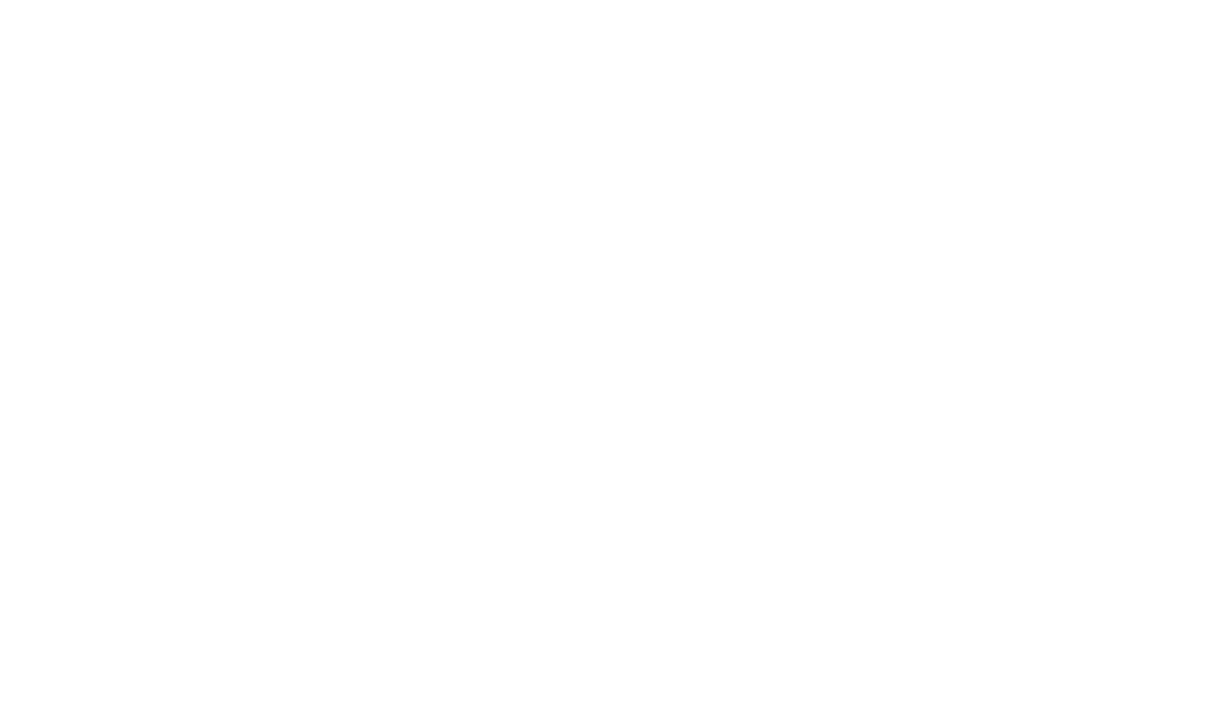

In [26]:
%pdb
white_output = 'output_videos/birdview_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(fitline_processing_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [ ]:
import math
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def change_color_space(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hsv
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices, extra_mask = None):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    if extra_mask is not None:
        mask = cv2.bitwise_and(mask, extra_mask)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
        
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
        
    ysize, xsize, *_ = img.shape
    ymid = ysize*3//5 # position end the line (it starts the y = ysize)
    
    
    line_sides = [[],[]]
    
    for line in lines:
        x1,y1,x2,y2 = line[0]
        
        if y1 == y2:
            continue # discart horizontal line

        x_at = lambda y_at: ((x2-x1)*y_at + y2*x1 - y1*x2 )//(y2-y1)
        low_x = x_at(ysize)

        if not 0 < low_x < xsize:
            continue # not starting on the car

        mid_x = x_at(ymid)
        
        # save line bounds for each side
        if (x1>x2) == (y1>y2):
            line_sides[0].append([low_x,mid_x])
        else:
            line_sides[1].append([low_x,mid_x])
    
    
    l1_deviation = 3 # tolarance for median deviation
    for line_bounds in line_sides:
        line_bounds = np.array(line_bounds)
        # use median to avoid outliers
        median = np.median(line_bounds, axis=0)
        l1_median_error = l1_deviation*np.mean(np.abs(line_bounds - median),axis=0)
        filter_outlier = np.all((line_bounds >= median-l1_median_error) & (line_bounds <= median+l1_median_error), axis=1)
        # compute the mean of the line bounds, after filtering outliers
        low_x, mid_x = np.mean(line_bounds[filter_outlier], axis=0).astype(np.int)

        cv2.line(img,(low_x,ysize),(mid_x,ymid),255,3)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

yellow_range= (np.array([19,100,100], dtype=np.uint8),
               np.array([25,255,255], dtype=np.uint8))
white_range = (np.array([0,             0,70 *255//100], dtype=np.uint8),
               np.array([179, 5 *255//100,         255], dtype=np.uint8))
white_range2= (np.array([  0,           0,90 *255//100], dtype=np.uint8),
               np.array([179,12 *255//100,         255], dtype=np.uint8))

def line_colors_mask(image):
    # Change to a better suited color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # Threshold the HSV image, white is broken into to ranges, because of its behavior on HSV
    white_mask = cv2.bitwise_or(cv2.inRange(hsv, *white_range), cv2.inRange(hsv, *white_range2))
    yellow_mask = cv2.inRange(hsv, *yellow_range)
    # Add masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    # Dilate masks to include borders
    mask = cv2.dilate(mask, None, iterations=5)  
    mask = cv2.erode(mask, None, iterations=3)
    return mask


In [ ]:
from matplotlib.colors import LogNorm
img = mpimg.imread('test_hist/lanes_with_light.jpg')
cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
plt.imshow(img[:,:,1], cmap='gray')
plt.figure()
H = img[:,:,0].flatten()
S = img[:,:,1].flatten()
V = img[:,:,2].flatten()
#python
nbins = 100
plt.hist2d(H[V>2], S[V>2], bins=nbins, norm=LogNorm())
plt.xlabel('H')
plt.ylabel('S')
plt.xlim([0,179])
plt.ylim([0,255])

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
%pdb
from pathlib import Path

input_dir = Path('test_images/')
for input_image in input_dir.iterdir():
    img = mpimg.imread(input_image.relative_to('.'))

    plt.figure(figsize=(30,20))
    plt.subplot(1, 7, 1)
    plt.imshow(img)
    lanes_image = change_color_space(img)
    ysize, xsize, _ = lanes_image.shape
    kernel_size = min(xsize,ysize)//200*2+1
    plt.subplot(1, 7, 2)
    plt.imshow(lanes_image, cmap='gray') 
    
    lanes_image = gaussian_blur(lanes_image, kernel_size)
    
    
    plt.subplot(1, 7, 3)
    plt.imshow(lanes_image, cmap='gray')
    
    lanes_image = canny(lanes_image, 100, 150)
    plt.subplot(1, 7, 4)
    plt.imshow(lanes_image, cmap='gray') 
    
    vertices = np.array([(xsize//10,ysize), (xsize*2//5, ysize*3//5), (xsize*3//5, ysize*3//5) , (xsize*9//10, ysize)], dtype=np.int32)
    lanes_image = region_of_interest(lanes_image, [vertices], line_colors_mask(img))
    plt.subplot(1, 7, 5)
    plt.imshow(lanes_image, cmap='gray')
    
    diag = int(math.sqrt(ysize**2+xsize**2))
    rho = 2
    theta = 1/60.
    votes = diag//30
    min_line = ysize//40
    max_gap = ysize//10
    lanes_image = hough_lines(lanes_image, rho, theta, votes, min_line, max_gap)
    plt.subplot(1, 7, 6)
    plt.imshow(lanes_image)
    lanes_image = weighted_img(lanes_image, img, α=0.8, β=1., γ=0.)
    plt.subplot(1, 7, 7)
    plt.imshow(lanes_image)
    print("{:>30} -> Votes: {}, MinSize: {}, MaxGap: {}, kernel size: {}".format(input_image.name, votes, min_line, max_gap,kernel_size))


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    lanes_image = change_color_space(image)
    
    ysize, xsize, _ = lanes_image.shape
    kernel_size = min(xsize,ysize)//200*2+1
    lanes_image = gaussian_blur(lanes_image, kernel_size)
    
    lanes_image = canny(lanes_image, 100, 150)

    ysize, xsize = lanes_image.shape
    vertices = np.array([(xsize//10,ysize), (xsize*2//5, ysize*3//5), (xsize*3//5, ysize*3//5) , (xsize*9//10, ysize)], dtype=np.int32)
    lanes_image = region_of_interest(lanes_image, [vertices], line_colors_mask(image))
    
    diag = int(math.sqrt(ysize**2+xsize**2))
    rho = 2
    theta = 1/60.
    votes = diag//30
    min_line = ysize//40
    max_gap = ysize//10
    lanes_image = hough_lines(lanes_image, rho, theta, votes, min_line, max_gap)
    
    return weighted_img(lanes_image, image, α=0.8, β=1., γ=0.)

Let's try the one with the solid white lane on the right first ...

In [ ]:
%pdb
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
import cv2
cv2.Sobel